In [1]:
import numpy as np
import mxnet as mx
import time
from matplotlib import pyplot as plt
from PIL import Image
import densecrf as dcrf

%matplotlib inline
plt.rcParams['figure.figsize'] = (25, 30)

# pallete encoding
pallete = [ 0,0,0, # 0: bk
            128,0,0, # 1: aero plane
            0,128,0, # 2: bicycle
            128,128,0, # 3: bird
            0,0,128, # 4: boat
            128,0,128, # 5: bottle
            0,128,128, # 6: bus
            128,128,128, # 7: car 
            64,0,0, # 8: cat
            192,0,0, # 9: chair
            64,128,0, # 10: cow
            192,128,0, # 11: dining table
            64,0,128, # 12: dog
            192,0,128, # 13: horse
            64,128,128, # 14: motor bike
            192,128,128, # 15: person
            0,64,0, # 16: potted plant
            128,64,0, # 17: sheep
            0,192,0, # 18: sofa
            128,192,0, # 19: train
            0,64,128 ] # 20: tv monitor

# image read and pre-processing

def get_data(img_path):
    """get the (1, 3, h, w) np.array data for the img_path"""
    mean = np.array([123.68, 116.779, 103.939])  # (R,G,B)
    img = Image.open(img_path)
    # To nparray
    img = np.array(img, dtype=np.float32)
    # Substract mean for each channel
    reshaped_mean = mean.reshape(1, 1, 3)
    img = img - reshaped_mean
    # swap channels
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    # 4D tensors
    img = np.expand_dims(img, axis=0)
    return img

OpenCV is unavailable.


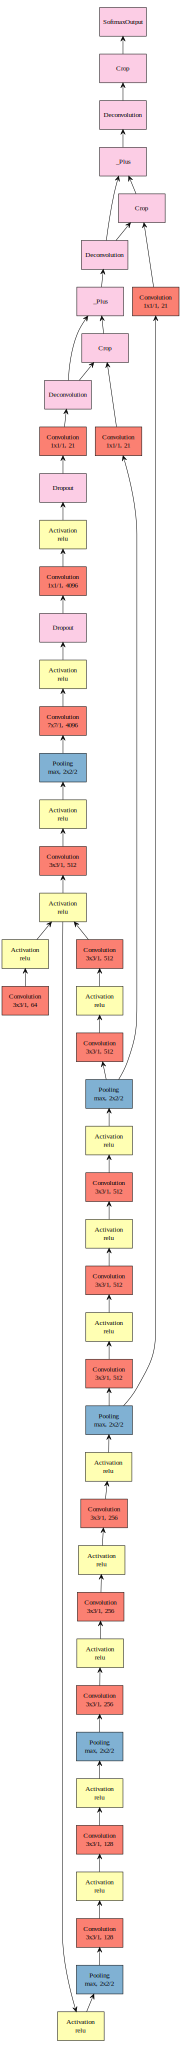

In [2]:
# load model
model_previx = "FCN_gpu0"
epoch = 19
ctx = mx.gpu(0)
fcnxs, fcnxs_args, fcnxs_auxs = mx.model.load_checkpoint(model_previx, epoch)
# fcnxs.list_arguments()
# visualization
mx.visualization.plot_network(fcnxs)

Time Lapsed: 0.11784148216247559 seconds.
(1, 21, 319, 500)


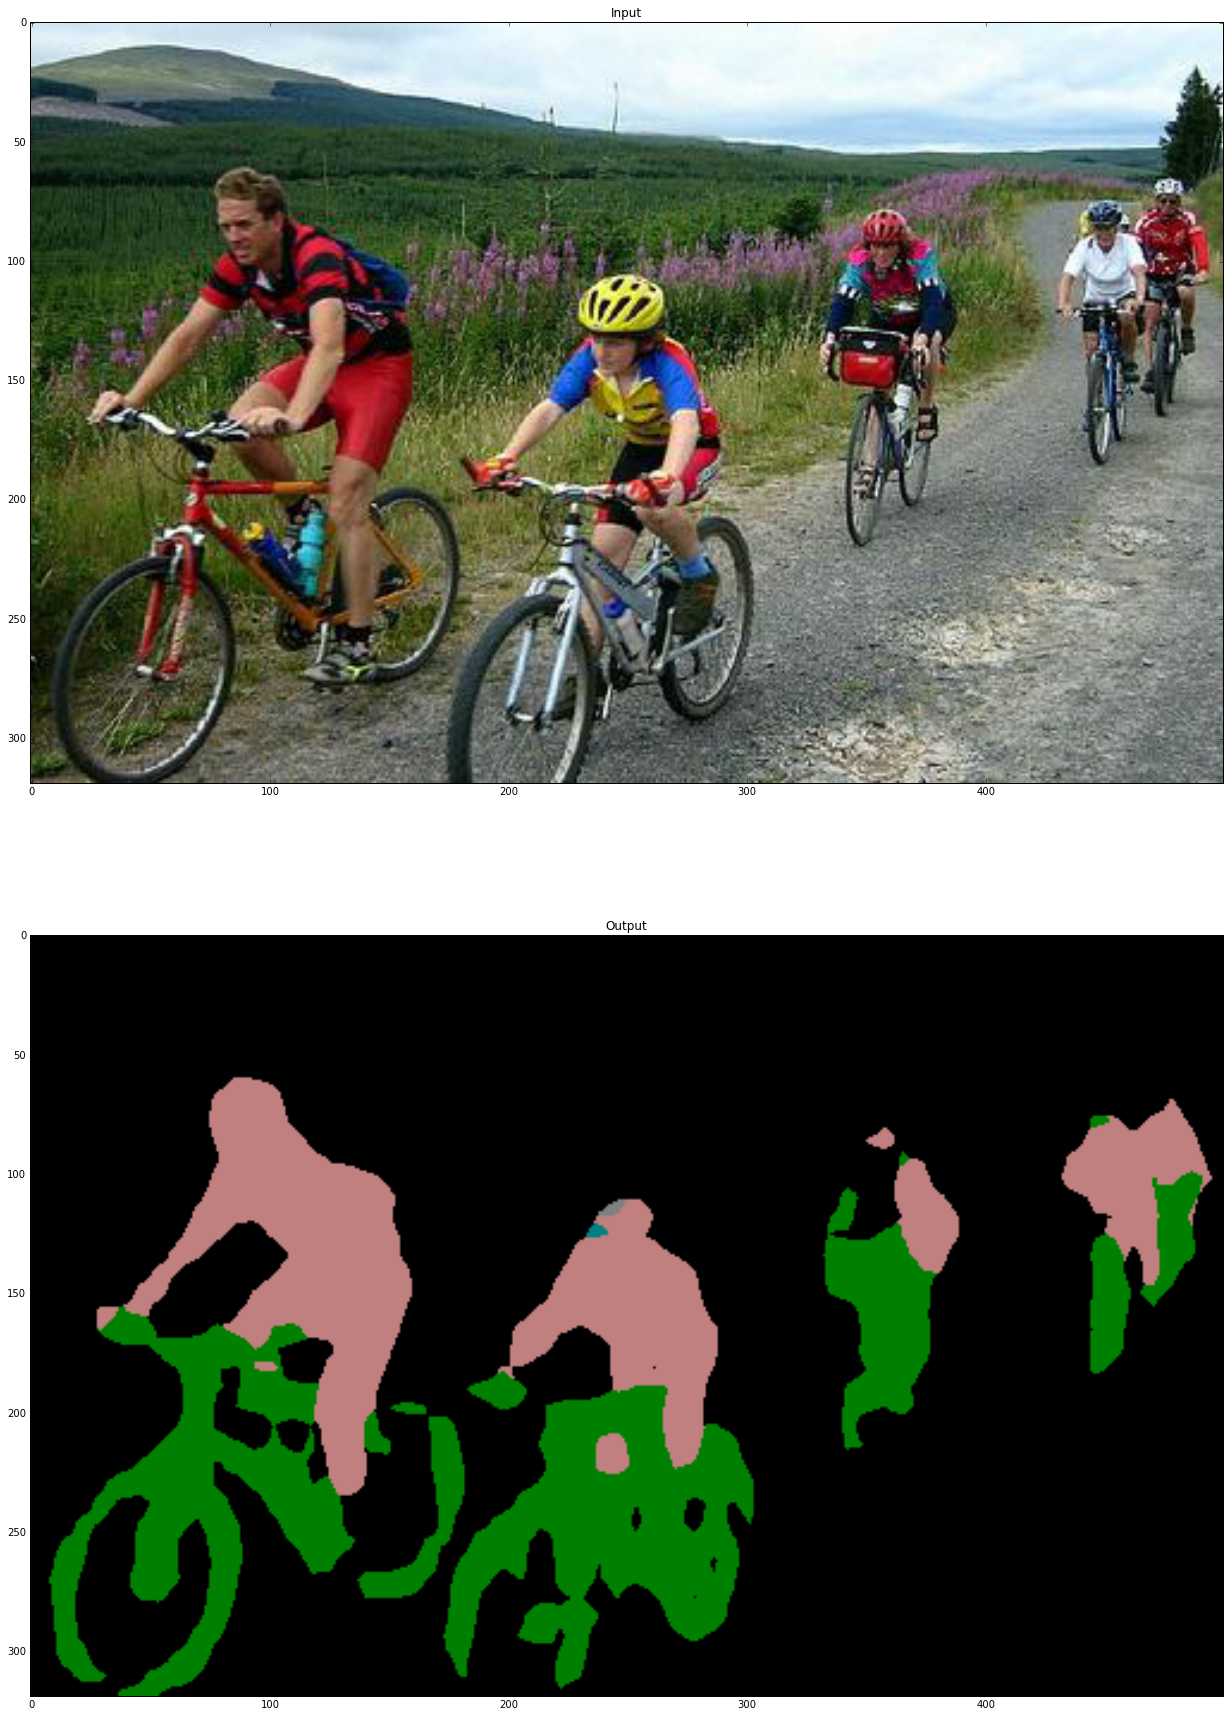

In [3]:
# input layers are adaptive to image size
img = "./person_bicycle.jpg"
# img = "./bus_train.jpg"
# img = "./llama.jpg"
# img = "./horse_sheep.jpg"
# img = "./dog_bird.png"


fcnxs_args["data"] = mx.nd.array(get_data(img), ctx)
data_shape = fcnxs_args["data"].shape
label_shape = (1, data_shape[2]*data_shape[3])
fcnxs_args["softmax_label"] = mx.nd.empty(label_shape, ctx)
img_vis = Image.open(img)
plt.subplot(2, 1, 1)
plt.title("Input")
plt.imshow(img_vis)
# do one feed-forward passing
time_before = time.time()
exector = fcnxs.bind(ctx, fcnxs_args ,args_grad=None, grad_req="null", aux_states=fcnxs_args)
exector.forward(is_train=False)
print("Time Lapsed: "+ str(time.time()-time_before)+" seconds.")
output = exector.outputs[0]
print(output.shape)
# nlayer * width * height
seg = img.replace(".jpg", "_unary.png")
out_img = np.uint8(np.squeeze(output.asnumpy().argmax(axis=1)))
out_img = Image.fromarray(out_img)
out_img.putpalette(pallete)
out_img.save(seg)
plt.subplot(2, 1, 2)
plt.title("Output")
plt.imshow(out_img)

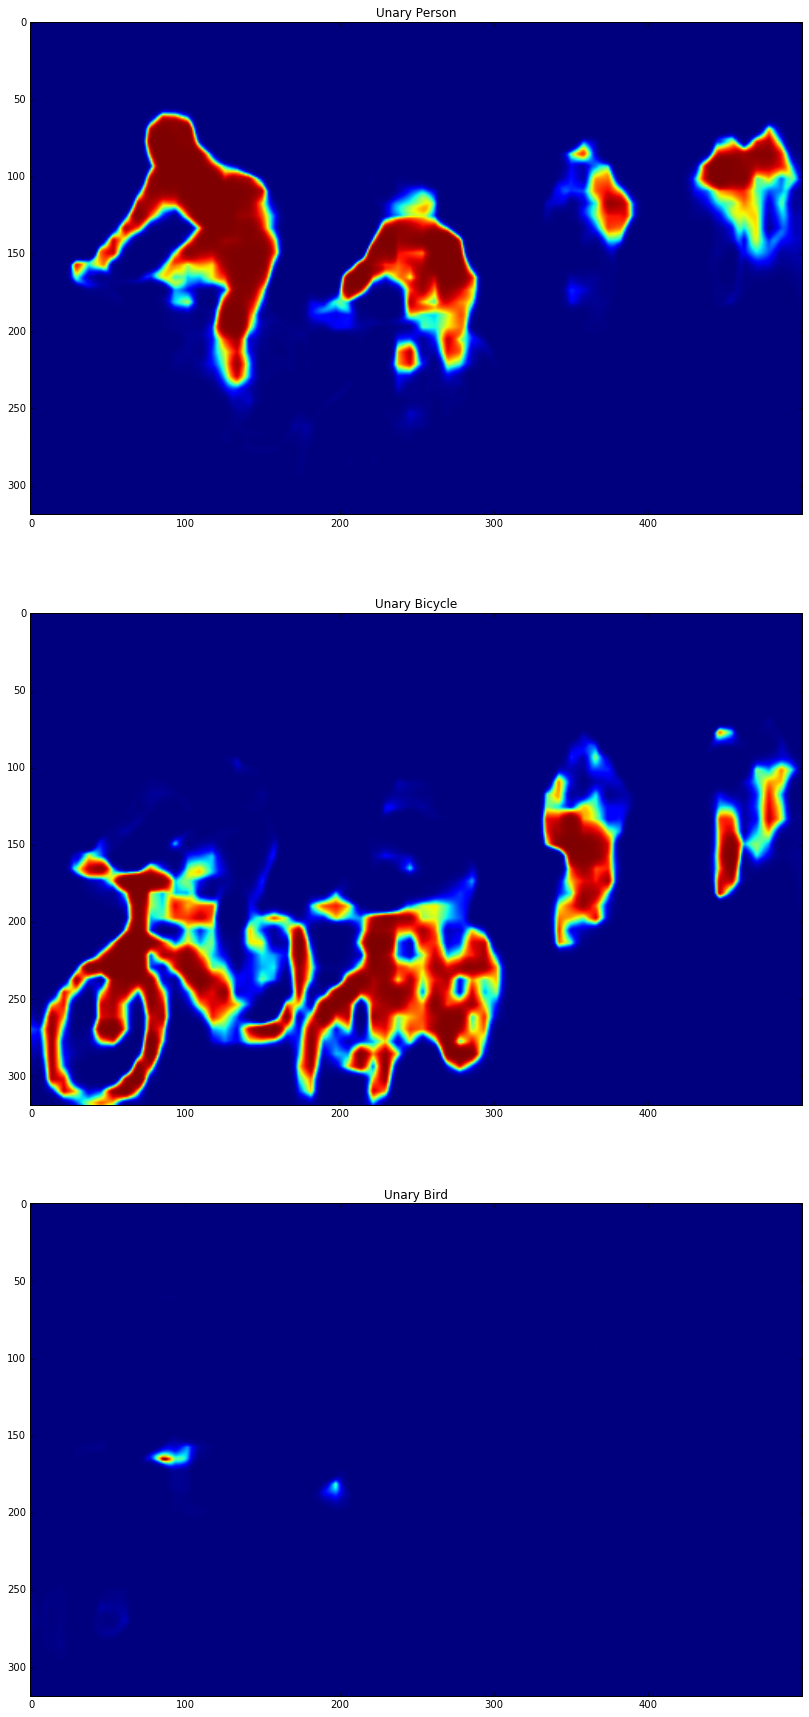

In [4]:
unary = output.asnumpy()
# person
unary_person = unary[0, 15]
# bicycle
unary_bicycle = unary[0, 2]
# bird
unary_bird = unary[0, 3]
plt.subplot(3, 1, 1)
plt.title("Unary Person")
plt.imshow(unary_person)
plt.subplot(3, 1, 2)
plt.title("Unary Bicycle")
plt.imshow(unary_bicycle)
plt.subplot(3, 1, 3)
plt.title("Unary Bird")
plt.imshow(unary_bird)

Time Lapsed: 0.8395452499389648 seconds.


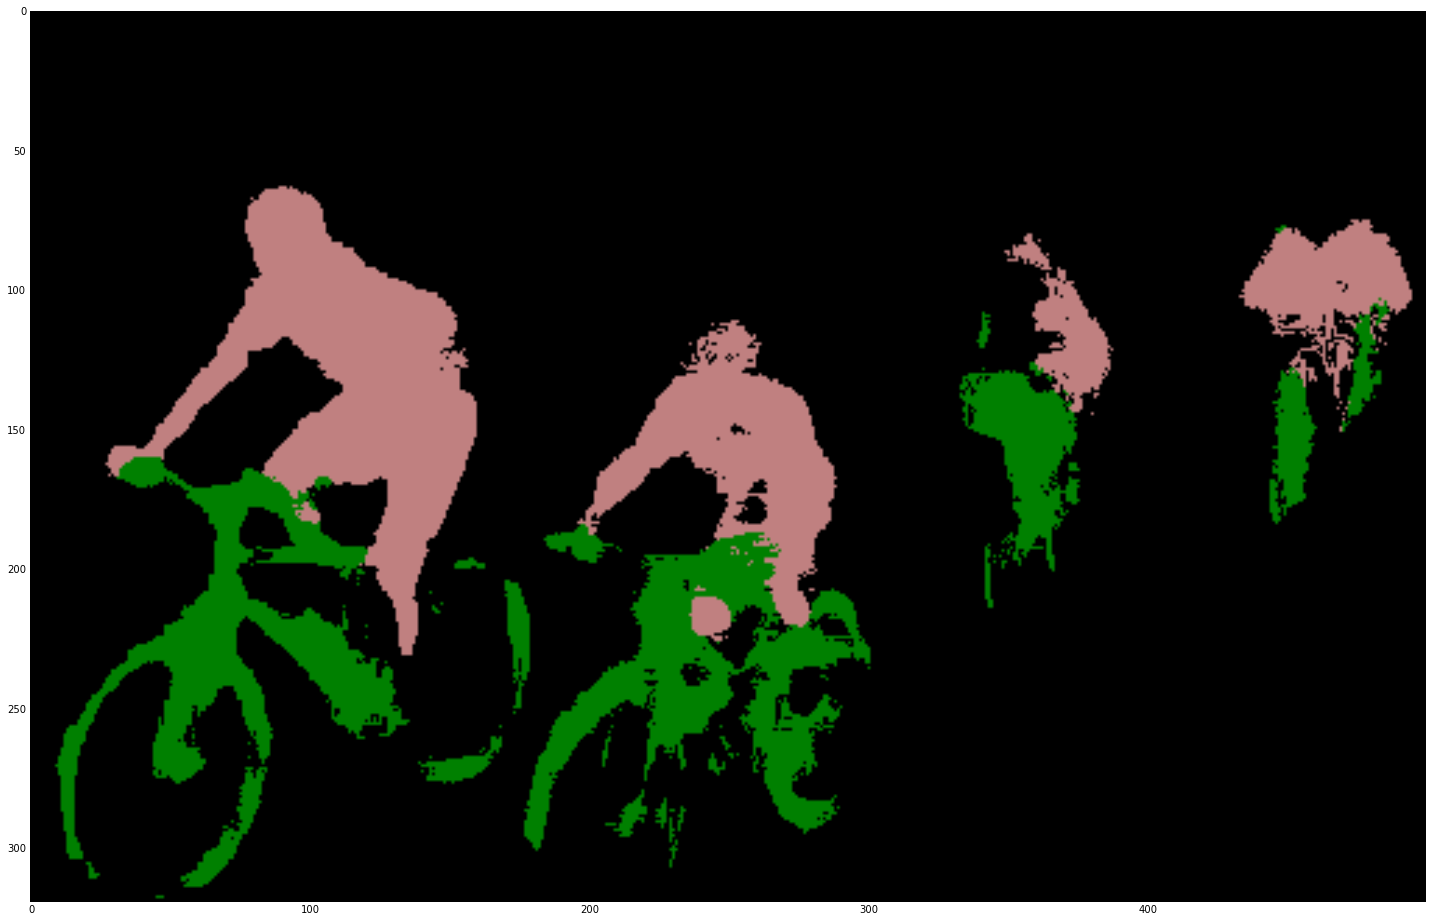

In [5]:
# DenseCRF as post-processing
# width, height, label
n_label = unary.shape[1]
im_height = unary.shape[2]
im_width = unary.shape[3]

d = dcrf.DenseCRF2D(im_height, im_width, n_label)
U = unary.reshape((n_label,-1)) # Needs to be flat..reshape((n_label, im_height*im_width))
Up = (U+0.001) / (np.sum(U, axis=0))
img_np = np.array(img_vis)

# change to negative log probability for numerical reasons
d.setUnaryEnergy(-np.log(Up))
# gaussian pairwise potential
d.addPairwiseGaussian(3, 1.5) # sigma_xy, comp # 3 1.5

# bilateral pairwise potential
d.addPairwiseBilateral(60, 10, img_np, 3)  # 60 10 3
time_before = time.time()
Q = d.inference(10)
print("Time Lapsed: "+ str(time.time()-time_before)+" seconds.")
Q = np.array(Q).reshape((n_label, im_height,im_width))

out_label = np.argmax(Q, axis=0)
out_img = Image.fromarray(np.uint8(out_label))
out_img.putpalette(pallete)
plt.imshow(out_img)

KL-divergence at 0: -508934.55263812275
KL-divergence at 1: -557035.2322924557
KL-divergence at 2: -562479.0785779709
KL-divergence at 3: -564179.1481216653
KL-divergence at 4: -564929.5134243735


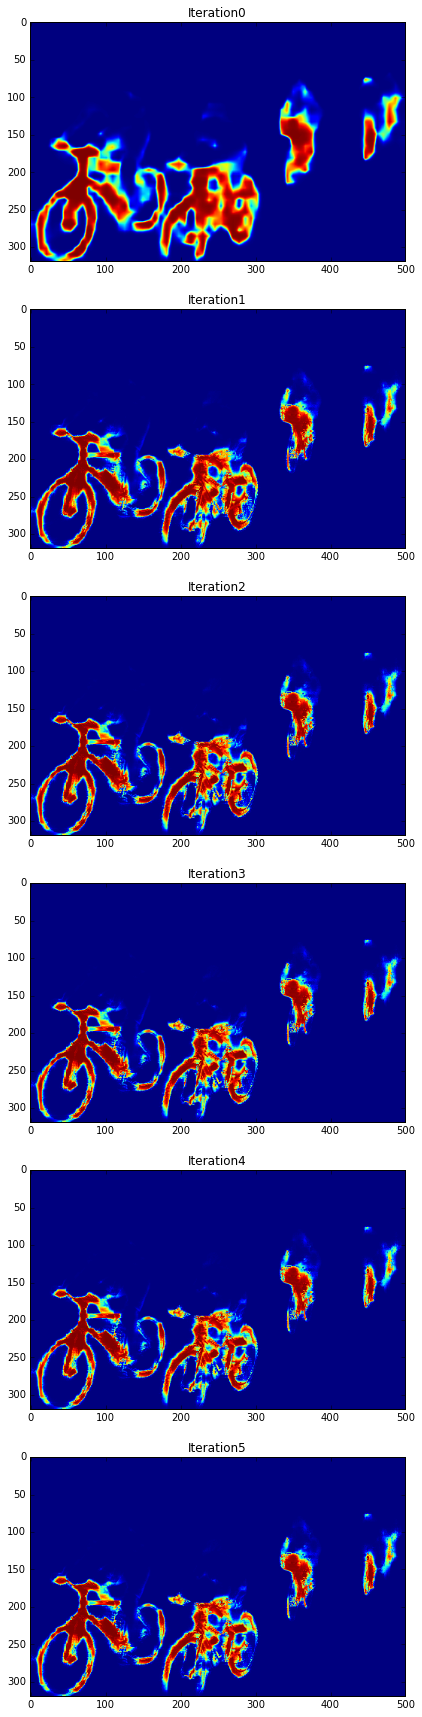

In [6]:
# step inference

label_idx = 2; # 2 for bicycle, 15 for person
d_step = dcrf.DenseCRF2D(im_height, im_width, n_label)
d_step.setUnaryEnergy(-np.log(Up))
d_step.addPairwiseGaussian(3, 1.5) # sigma_xy, comp
d_step.addPairwiseBilateral(60, 10, img_np, 3) 

Q, tmp1, tmp2 = d.startInference()
Q_np = np.array(Q).reshape((n_label, im_height,im_width))
plt.subplot(6, 1, 1)
plt.title("Iteration"+str(0))
plt.imshow(Q_np[label_idx])
for i in range(5):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d_step.stepInference(Q, tmp1, tmp2)
    Q_np = np.array(Q).reshape((n_label, im_height,im_width))
    plt.subplot(6, 1, i+2)
    plt.title("Iteration"+str(i+1))
    plt.imshow(Q_np[label_idx])

Time Lapsed: 0.0017807483673095703 seconds.
(1, 21, 334, 500)
KL-divergence at 0: -620772.9391102988
KL-divergence at 1: -668412.4927176804
KL-divergence at 2: -674538.5994250448


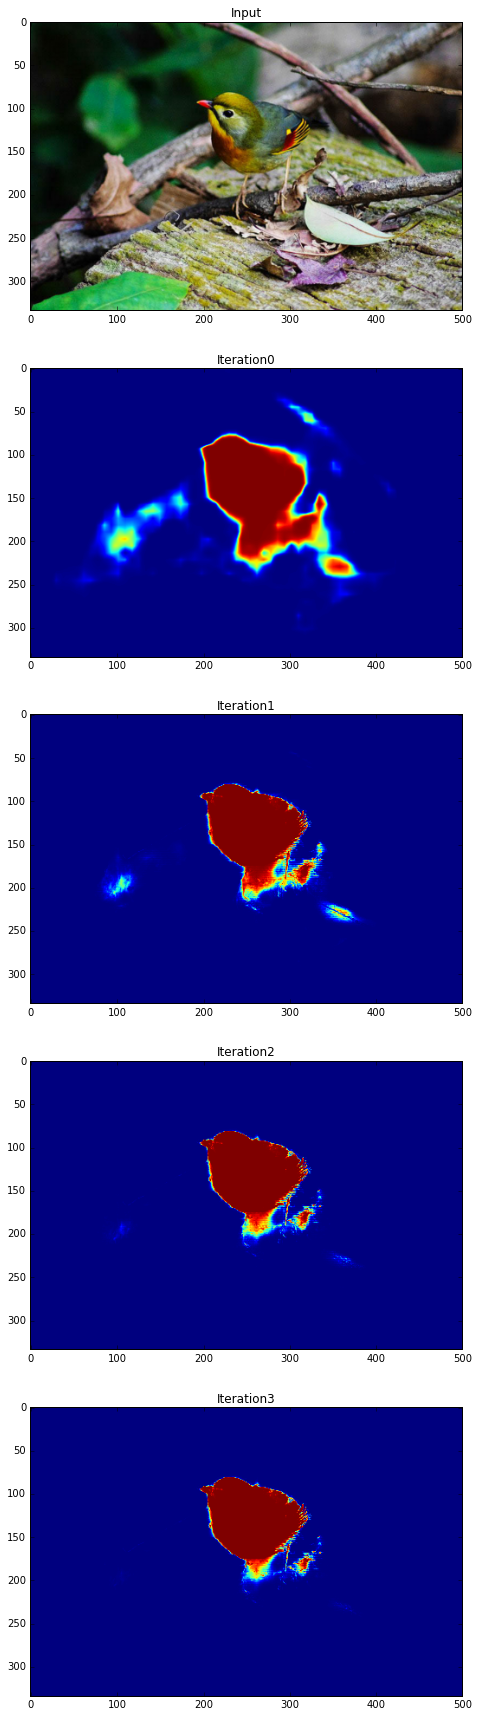

In [7]:
# input layers are adaptive to image size
img = "./bird.png"

fcnxs_args["data"] = mx.nd.array(get_data(img), ctx)
data_shape = fcnxs_args["data"].shape
label_shape = (1, data_shape[2]*data_shape[3])
fcnxs_args["softmax_label"] = mx.nd.empty(label_shape, ctx)
img_vis = Image.open(img)

# do one feed-forward passing
time_before = time.time()
exector = fcnxs.bind(ctx, fcnxs_args ,args_grad=None, grad_req="null", aux_states=fcnxs_args)
exector.forward(is_train=False)
print("Time Lapsed: "+ str(time.time()-time_before)+" seconds.")
output = exector.outputs[0]
print(output.shape)

unary = output.asnumpy()

# nlayer * width * height

# DenseCRF as post-processing
# width, height, label
n_label = unary.shape[1]
im_height = unary.shape[2]
im_width = unary.shape[3]

d = dcrf.DenseCRF2D(im_height, im_width, n_label)
U = unary.reshape((n_label,-1)) # Needs to be flat..reshape((n_label, im_height*im_width))
Up = U / (np.sum(U, axis=0) + 0.01)
img_np = np.array(img_vis)

# change to negative log probability for numerical reasons
d.setUnaryEnergy(-np.log(Up))
# gaussian pairwise potential
d.addPairwiseGaussian(3, 1.5) # sigma_xy, comp

# bilateral pairwise potential
d.addPairwiseBilateral(60, 10, img_np, 3) 
time_before = time.time()

label_idx = 3; # 2 for bicycle, 15 for person, 3 for bird
d_step = dcrf.DenseCRF2D(im_height, im_width, n_label)
d_step.setUnaryEnergy(-np.log(Up))
d_step.addPairwiseGaussian(3, 2) # sigma_xy, comp
d_step.addPairwiseBilateral(60, 10, img_np, 5) 

Q, tmp1, tmp2 = d.startInference()
Q_np = np.array(Q).reshape((n_label, im_height,im_width))
plt.subplot(5, 1, 1)
plt.title("Input")
plt.imshow(img_vis)
plt.subplot(5, 1, 2)
plt.title("Iteration"+str(0))
plt.imshow(Q_np[label_idx])
for i in range(3):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d_step.stepInference(Q, tmp1, tmp2)
    Q_np = np.array(Q).reshape((n_label, im_height,im_width))
    plt.subplot(5, 1, i+3)
    plt.title("Iteration"+str(i+1))
    plt.imshow(Q_np[label_idx])

Time Lapsed: 0.0030031204223632812 seconds.
(1, 21, 240, 328)
KL-divergence at 0: -252719.9607223525
KL-divergence at 1: -271383.3477288071
KL-divergence at 2: -272641.0161190575


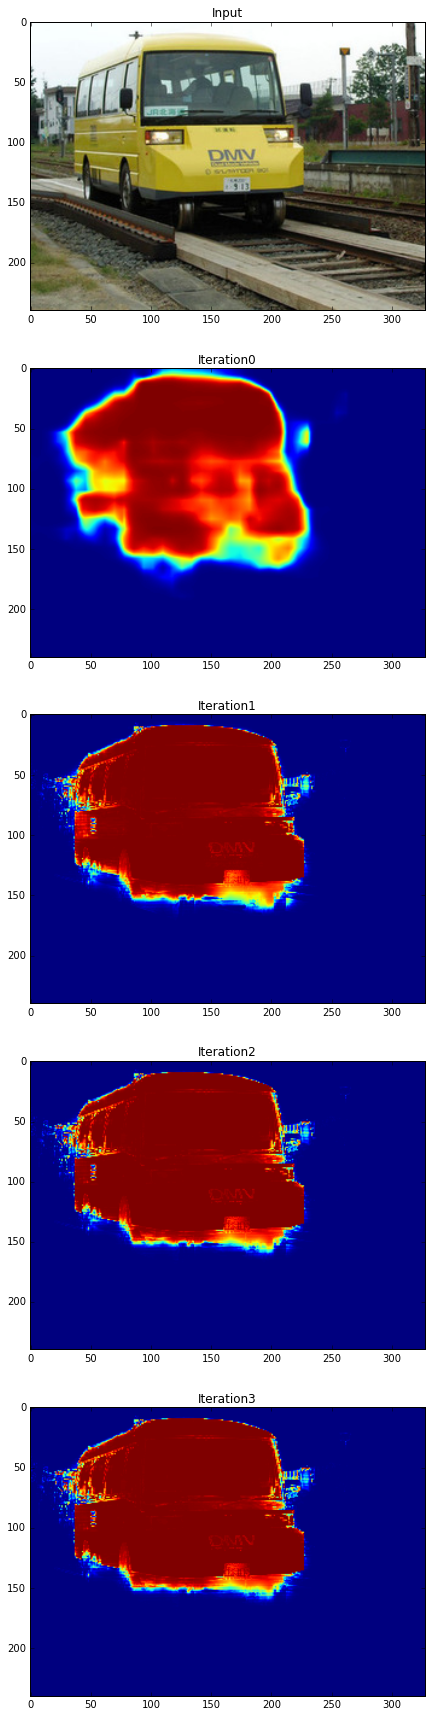

In [9]:
# input layers are adaptive to image size
# img = "./bird.png"
img = "./bus_train.jpg"


fcnxs_args["data"] = mx.nd.array(get_data(img), ctx)
data_shape = fcnxs_args["data"].shape
label_shape = (1, data_shape[2]*data_shape[3])
fcnxs_args["softmax_label"] = mx.nd.empty(label_shape, ctx)
img_vis = Image.open(img)

# do one feed-forward passing
time_before = time.time()
exector = fcnxs.bind(ctx, fcnxs_args ,args_grad=None, grad_req="null", aux_states=fcnxs_args)
exector.forward(is_train=False)
print("Time Lapsed: "+ str(time.time()-time_before)+" seconds.")
output = exector.outputs[0]
print(output.shape)

unary = output.asnumpy()

# nlayer * width * height

# DenseCRF as post-processing
# width, height, label
n_label = unary.shape[1]
im_height = unary.shape[2]
im_width = unary.shape[3]

d = dcrf.DenseCRF2D(im_height, im_width, n_label)
U = unary.reshape((n_label,-1)) # Needs to be flat..reshape((n_label, im_height*im_width))
Up = U / (np.sum(U, axis=0) + 0.01)
img_np = np.array(img_vis)

# change to negative log probability for numerical reasons
d.setUnaryEnergy(-np.log(Up))
# gaussian pairwise potential
d.addPairwiseGaussian(3, 1.5) # sigma_xy, comp

# bilateral pairwise potential
d.addPairwiseBilateral(60, 10, img_np, 3) 
time_before = time.time()

label_idx = 6; # 2 for bicycle, 15 for person, 3 for bird
d_step = dcrf.DenseCRF2D(im_height, im_width, n_label)
d_step.setUnaryEnergy(-np.log(Up))
d_step.addPairwiseGaussian(3, 2) # sigma_xy, comp
d_step.addPairwiseBilateral(60, 10, img_np, 5) 

Q, tmp1, tmp2 = d.startInference()
Q_np = np.array(Q).reshape((n_label, im_height,im_width))
plt.subplot(5, 1, 1)
plt.title("Input")
plt.imshow(img_vis)
plt.subplot(5, 1, 2)
plt.title("Iteration"+str(0))
plt.imshow(Q_np[label_idx])
for i in range(3):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d_step.stepInference(Q, tmp1, tmp2)
    Q_np = np.array(Q).reshape((n_label, im_height,im_width))
    plt.subplot(5, 1, i+3)
    plt.title("Iteration"+str(i+1))
    plt.imshow(Q_np[label_idx])

Time Lapsed: 0.0010895729064941406 seconds.
(1, 21, 364, 500)
KL-divergence at 0: -610806.511536026
KL-divergence at 1: -634137.550652486
KL-divergence at 2: -635656.4431988599


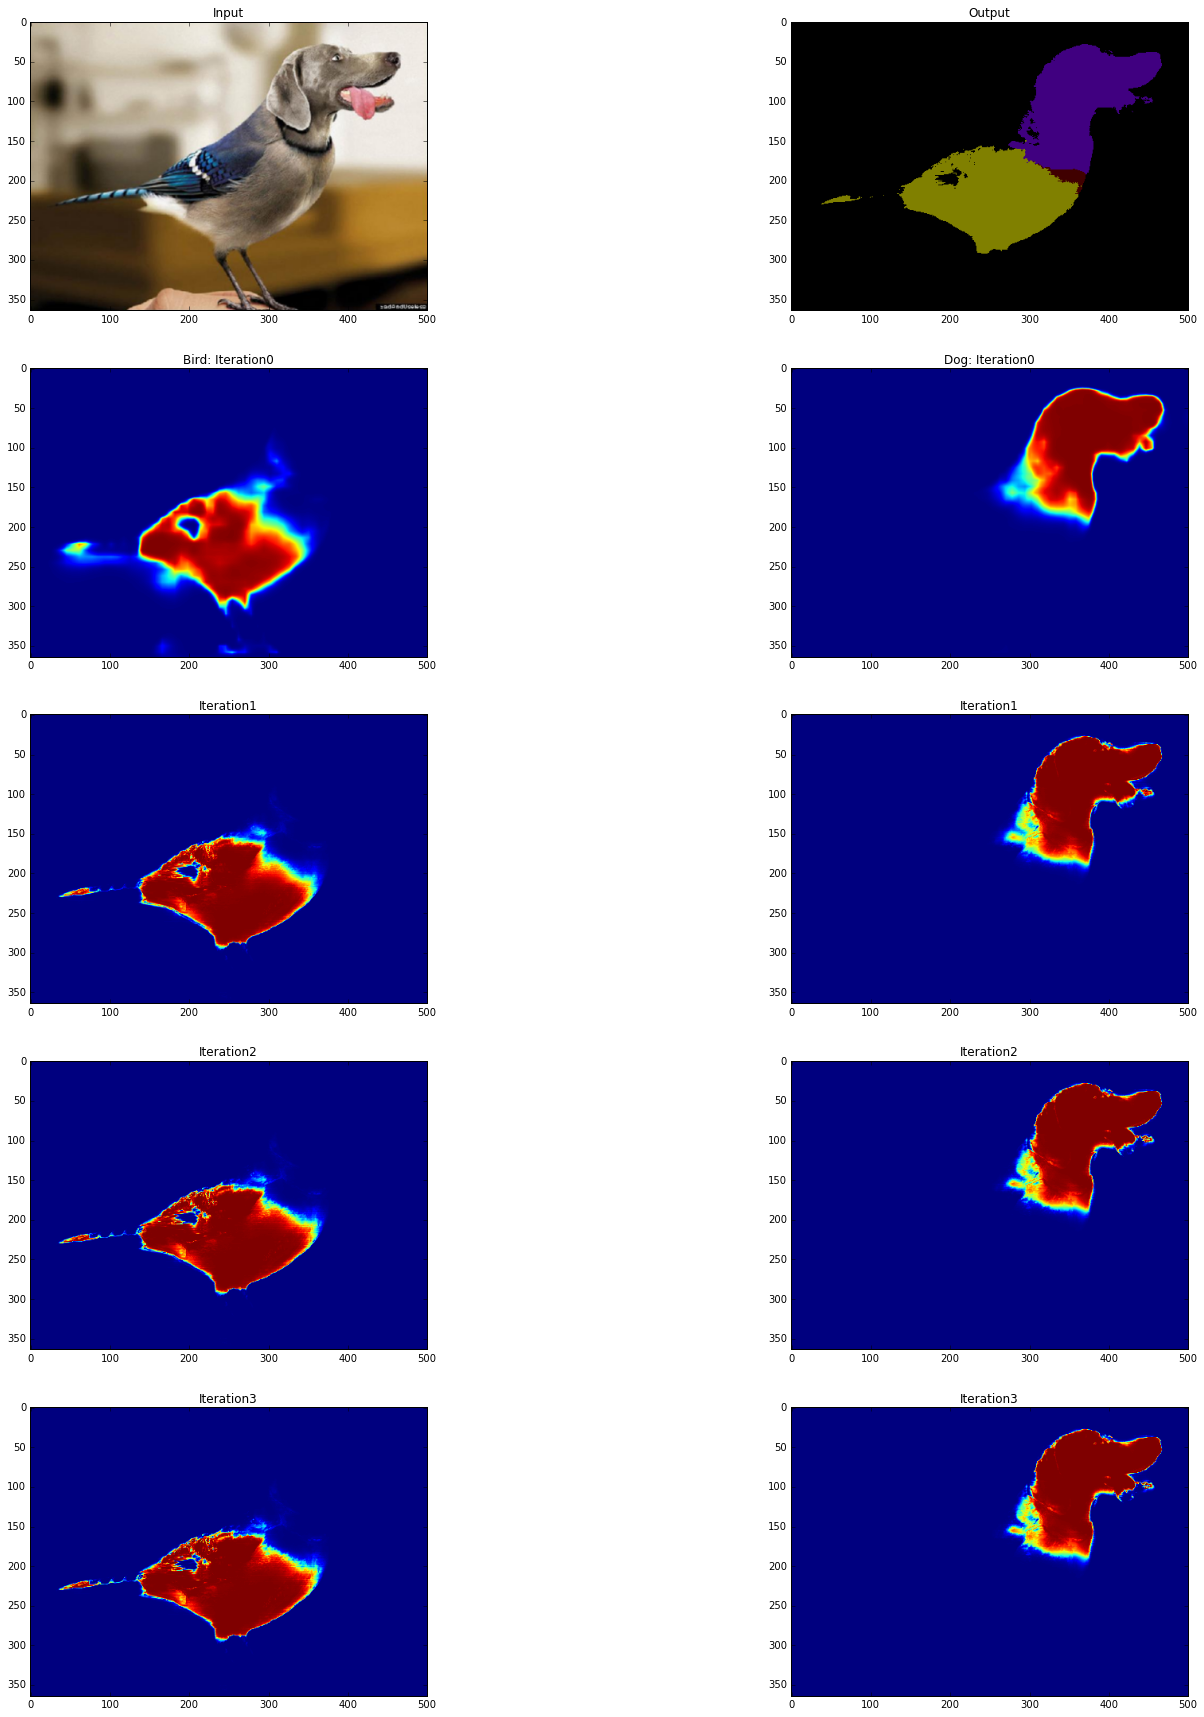

In [12]:
# input layers are adaptive to image size
img = "./dog_bird.png"

fcnxs_args["data"] = mx.nd.array(get_data(img), ctx)
data_shape = fcnxs_args["data"].shape
label_shape = (1, data_shape[2]*data_shape[3])
fcnxs_args["softmax_label"] = mx.nd.empty(label_shape, ctx)
img_vis = Image.open(img)

# do one feed-forward passing
time_before = time.time()
exector = fcnxs.bind(ctx, fcnxs_args ,args_grad=None, grad_req="null", aux_states=fcnxs_args)
exector.forward(is_train=False)
print("Time Lapsed: "+ str(time.time()-time_before)+" seconds.")
output = exector.outputs[0]
print(output.shape)

unary = output.asnumpy()

# nlayer * width * height

# DenseCRF as post-processing
# width, height, label
n_label = unary.shape[1]
im_height = unary.shape[2]
im_width = unary.shape[3]

d = dcrf.DenseCRF2D(im_height, im_width, n_label)
U = unary.reshape((n_label,-1)) # Needs to be flat..reshape((n_label, im_height*im_width))
Up = U / (np.sum(U, axis=0) + 0.01)
img_np = np.array(img_vis)

# change to negative log probability for numerical reasons
d.setUnaryEnergy(-np.log(Up))
# gaussian pairwise potential
d.addPairwiseGaussian(3, 1.5) # sigma_xy, comp

# bilateral pairwise potential
d.addPairwiseBilateral(60, 10, img_np, 3) 
time_before = time.time()

label_idx = 3; # 2 for bicycle, 15 for person, 3 for bird
label_idx2 = 12; # 2 for bicycle, 15 for person, 3 for bird
d_step = dcrf.DenseCRF2D(im_height, im_width, n_label)
d_step.setUnaryEnergy(-np.log(Up))
d_step.addPairwiseGaussian(3, 2) # sigma_xy, comp
d_step.addPairwiseBilateral(60, 10, img_np, 5) 

Q, tmp1, tmp2 = d.startInference()
Q_np = np.array(Q).reshape((n_label, im_height,im_width))
plt.subplot(5, 2, 1)
plt.title("Input")
plt.imshow(img_vis)
plt.subplot(5, 2, 3)
plt.title("Bird: Iteration"+str(0))
plt.imshow(Q_np[label_idx])
plt.subplot(5, 2, 4)
plt.title("Dog: Iteration"+str(0))
plt.imshow(Q_np[label_idx2])
for i in range(3):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d_step.stepInference(Q, tmp1, tmp2)
    Q_np = np.array(Q).reshape((n_label, im_height,im_width))
    plt.subplot(5, 2, i*2+5)
    plt.title("Iteration"+str(i+1))
    plt.imshow(Q_np[label_idx])
    plt.subplot(5, 2, i*2+6)
    plt.title("Iteration"+str(i+1))
    plt.imshow(Q_np[label_idx2])
plt.subplot(5, 2, 2)
plt.title("Output")
Q = np.array(Q).reshape((n_label, im_height,im_width))
out_label = np.argmax(Q, axis=0)
out_img = Image.fromarray(np.uint8(out_label))
out_img.putpalette(pallete)
plt.imshow(out_img)